In [1]:
trainingOHCA_fileName = "generatedPoints1_100000_area.csv"
candidateAED_fileName = "buildings_locations_area.csv"
# trainingOHCA_fileName = r"D:\MyDownloads\generatedPoints1_100000_subzone.csv"
# candidateAED_fileName = r"D:\MyDownloads\buildings_locations_subzone.csv"
testOHCA_fileName = "generatedPoints2_15000.csv"
currentAED_fileName = "AED Details_As of 27 March 2019 (2).xlsx"

In [2]:
import pandas as pd
import numpy as np
from haversine import haversine_vector, Unit
from haversine import haversine
from os import path
import scipy.sparse
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum
from pulp import *
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt     
import seaborn as sns
from itertools import combinations
from sklearn import preprocessing, cluster
from sklearn.metrics import silhouette_score
import scipy
import scipy.cluster
from matplotlib import colors as mcolors
from skimage.io import imread
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
import time

In [3]:
def MCLP(S,OHCA_Cluster,AED_Cluster,d,P): #Input for MCLP to return the coordinates of AEDs to be placed
    
    # S is Distance beyond which is considered uncovered
    # P is the number of AEDs to be placed in that cluster 
    
    I = OHCA_Cluster.index.values.tolist() #Demand Node
    J = AED_Cluster.index.values.tolist() #Facility Node
    P = P
    #a = np.ones(len(OHCA_Cluster))
    
    # N is a list in which each item is a list of nodes within threshold distance of ith node
    N = [[j for j in J if d[i][j] < S] for i in I]
    #P = 2400 #Number of AEDs to be placed in this cluster
    
    #Optimization
    prob = LpProblem("MCLP",LpMaximize)
    x = LpVariable.dicts("x",J,0,1,cat="Integer")
    y = LpVariable.dicts("y",I,0,1,cat="Integer")
    #a = LpVariable.dicts("a",I,cat="Continuous")
    
    #Objective
    #prob += lpSum([a[i]*y[i] for i in I])
    prob += lpSum([y[i] for i in I])
    
    #Constraints
    for i in I:
        prob += lpSum([x[j] for j in N[i]]) >= y[i]
       # for j in N[i]:
            #if x[j] == 1:
                #prob += a[i] == 0.549*d[i][j]**-0.584
        #a[i] = [0.549*d[i][j]**-0.584 for j in N[i] if x[j] == 1]
        
    prob +=lpSum([x[j] for j in J]) == P

    #Solving
    #solver = getSolver('GUROBI')
    #prob.solve(solver)
    prob.solve(GUROBI(msg=0))
    
    x_soln = np.array([x[j].varValue for j in J])
    print ("OHCA Served is = ", value(prob.objective))
    AED_Chosen = pd.concat([AED_Cluster,pd.DataFrame(x_soln,columns=['x'])],axis=1)
    AED_Chosen = AED_Chosen[AED_Chosen['x'] == 1]
    AED_Chosen = AED_Chosen.drop(columns=['x'])
    return(AED_Chosen)

In [4]:
def kmeans_OHCA_AED(OHCA,AED,k=2): #k is the number of clusters chosen
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(OHCA)
    
    OHCA_Cluster_All = pd.concat([OHCA,pd.DataFrame(kmeans.labels_,columns = ["cluster"])],axis=1)
    AED_lable = kmeans.predict(AED)
#     print(len(AED_lable))
    AED_Cluster_All = pd.concat([AED, pd.DataFrame(AED_lable,columns = ["cluster"])], axis=1)

    return OHCA_Cluster_All, AED_Cluster_All

In [5]:
# input: two clusters 
# output: All_AED_in_Cluster
def MCLP_in_Cluster(OHCA1,candidateAED1,p_subzone,k=2):
    OHCA1_clusters, candidateAED1_clusters = kmeans_OHCA_AED(OHCA1, candidateAED1,k)
    All_AED_in_Cluster=pd.DataFrame(columns=['LatAED', 'LongAED']) 
    for i in range(k):
        OHCA20a = OHCA1_clusters[OHCA1_clusters['cluster']==i][["LatOHCA","LongOHCA"]].reset_index(drop=True)
        candidateAED20a = candidateAED1_clusters[candidateAED1_clusters['cluster']==i][["LatAED","LongAED"]].reset_index(drop=True)
        if len(candidateAED20a)>0:
            d1 = haverDist(OHCA20a,candidateAED20a)
            sub_AED_df = MCLP(100,OHCA20a,candidateAED20a,d1,int(p_subzone/k))
            All_AED_in_Cluster=All_AED_in_Cluster.append(sub_AED_df)
        else: pass
    return All_AED_in_Cluster

In [6]:
def kmeansPlot(OHCA_Cluster_All, k):
    colours = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
    for i in range(k):
        plt.scatter(x=OHCA_Cluster_All[OHCA_Cluster_All["cluster"]==i].iloc[:,0], y= OHCA_Cluster_All[OHCA_Cluster_All["cluster"]==i].iloc[:,1], s=5, c=colours[i])

In [7]:
def haverDist(OHCA_Cluster,AED_Cluster):
    d = haversine_vector(list(zip(OHCA_Cluster.LatOHCA, OHCA_Cluster.LongOHCA)), list(zip(AED_Cluster.LatAED, AED_Cluster.LongAED)), Unit.METERS, comb=True).T
    return(d)

In [8]:
#test_OHCA = pd.read_csv(testOHCA_fileName, names = ["LatOHCA", "LongOHCA"], header = None)
OHCA = pd.read_csv(trainingOHCA_fileName)
candidateAED = pd.read_csv(candidateAED_fileName)
# candidateAED.columns = ["LatAED","LongAED"]
P_count=OHCA['region'].value_counts()
len(P_count)

53

In [9]:
%%time

start_time = time.time()

ALL_AED= pd.DataFrame(columns=['LatAED', 'LongAED']) 
all_AED_num=9800
all_OHCA_num=97541

for subzone in range(1,56):
    if subzone!=14 and subzone != 48 :  
        p_subzone=int(P_count.at[subzone]*all_AED_num/all_OHCA_num)
        print(subzone, P_count.at[subzone], p_subzone )
        OHCA1=OHCA[OHCA['region']== subzone]
        OHCA1=OHCA1[['LatOHCA','LongOHCA']].reset_index(drop=True)
        candidateAED1 = candidateAED[candidateAED['region']==subzone].copy()
        candidateAED1 = candidateAED1[['LatAED','LongAED']].reset_index(drop=True)
        candidateAED1 = candidateAED1.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
        AED_sub =MCLP_in_Cluster(OHCA1,candidateAED1,p_subzone,2)
        ALL_AED=ALL_AED.append(AED_sub)
print("Time is --- %s seconds ---" % (time.time() - start_time))

1 4588 460
Academic license - for non-commercial use only - expires 2022-06-25
Using license file C:\Users\ISEdzh\gurobi.lic
OHCA Served is =  1520.0
OHCA Served is =  1908.0
2 1586 159
OHCA Served is =  850.0
OHCA Served is =  161.0
3 1932 194
OHCA Served is =  630.0
OHCA Served is =  644.0
4 1960 196
OHCA Served is =  None
OHCA Served is =  None
5 1123 112
OHCA Served is =  266.0
OHCA Served is =  76.0
6 1476 148
OHCA Served is =  733.0
OHCA Served is =  382.0
7 1796 180
OHCA Served is =  524.0
OHCA Served is =  752.0
8 4285 430
OHCA Served is =  2247.0
OHCA Served is =  1526.0
9 2791 280
OHCA Served is =  1028.0
OHCA Served is =  514.0
10 3835 385
OHCA Served is =  1728.0
OHCA Served is =  1442.0
11 3245 326
OHCA Served is =  1939.0
OHCA Served is =  765.0
12 97 9
OHCA Served is =  5.0
OHCA Served is =  2.0
13 1793 180
OHCA Served is =  88.0
OHCA Served is =  None
15 2113 212
OHCA Served is =  556.0
OHCA Served is =  1219.0
16 2377 238
OHCA Served is =  365.0
OHCA Served is =  1028.

In [162]:
print('The final Kmeans-MCLP AED result is in this dataframe below: ')
ALL_AED
# .reset_index(drop=True,inplace=True)

The final Kmeans-MCLP AED result is in this dataframe below: 


,LatAED,LongAED
0,1.278086,103.837117
11,1.275302,103.839207
15,1.274699,103.840485
19,1.273884,103.839003
24,1.274428,103.834879
...,...,...
1004,1.423678,103.834021
1009,1.423472,103.830623
1014,1.429589,103.835050
1022,1.429314,103.836523


In [ ]:
# New computing time
# Time is --- 162.2278265953064 seconds ---
# Wall time: 2min 42s

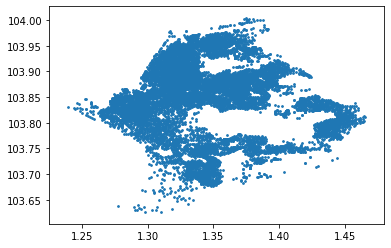

In [10]:
ALL_AED.to_csv('MCLP-MultiArea-KMeans-AED-Solution.csv')
plt.scatter(
   ALL_AED['LatAED'], 
   ALL_AED['LongAED'],s=3
)

In [ ]:
######################################################################################################
#Metrics
######################################################################################################

In [13]:
AED_Chosen_All_MCLP=ALL_AED.reset_index(drop=True)
#AED_Chosen_All_MCLP = pd.read_csv("MCLP_SingleBest_Output.csv",index_col=0)
#total coverage 
MCLP_TC = totalCoverage(OHCA,AED_Chosen_All_MCLP,100)
print("MCLP total coverage is : ", MCLP_TC)
#partial coverage
MCLP_PC = partial_coverage(OHCA,AED_Chosen_All_MCLP)
# print("MCLP partial coverage is : ", MCLP_PC)
# #expected survival
MCLP_ES = expectedsurvival(OHCA,AED_Chosen_All_MCLP)
print("MCLP expected survival is : ", MCLP_ES)
#average distance to nearest AED
MCLP_AD = average_distance(OHCA, AED_Chosen_All_MCLP)
print("MCLP average distance is : ", MCLP_AD)

total coverage =  0.6863165233081473
MCLP total coverage is :  0.6863165233081473
MCLP expected survival is :  0.49315151689066744
MCLP average distance is :  158.2720649470641


In [ ]:
# total coverage =  0.6863165233081473
# MCLP total coverage is :  0.6863165233081473

MCLP average distance is :  161.5120564656188


In [11]:
def totalCoverage(ohca_df, aed_df, MAX_DIST_METERS = 100):
    def ClosestAED(r):
        # Cartesian Distance: square root of (x2-x1)^2 + (y2-y1)^2
        distances = ((r['LatOHCA']-aed_df['LatAED'])**2 + (r['LongOHCA']-aed_df['LongAED'])**2)**0.5

        # AED with minimum Distance from the OHCA
        closestAEDId = distances[distances == distances.min()].index.to_list()[0]
        return aed_df.loc[closestAEDId, ['LatAED', 'LongAED']]

    cp_ohca = ohca_df.copy()
    cp_ohca[['ClosestAEDLatitude', 'ClosestAEDLongtitude']] = cp_ohca.apply(ClosestAED, axis=1)
    
    def haversine_np(lat1, lon1, lat2, lon2):
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
        c = 2 * np.arcsin(np.sqrt(a))
        km = 6367 * c
        return km * 1000
    
    cp_ohca['dist_nearest_AED'] = haversine_np(cp_ohca['LatOHCA'], cp_ohca['LongOHCA'],
                                               cp_ohca['ClosestAEDLatitude'], cp_ohca['ClosestAEDLongtitude'])
    # distance to nearest AED (in metres) is recorded for each OHCA
    
    cp_ohca.loc[cp_ohca['dist_nearest_AED'] <= 100, 'isCovered'] = 'covered'
    cp_ohca.loc[cp_ohca['dist_nearest_AED'] > 100,'isCovered'] = 'uncovered'
    # each OHCA having an AED within 100m has isCovered = 'covered', otherwise 'uncovered'
    #print(cp_ohca)
    
    
    within_100m  = sum(cp_ohca['isCovered'] == 'covered')
    outside_100m = len(cp_ohca) - within_100m
    total_coverage_within_100m = within_100m / (within_100m + outside_100m)
    print("total coverage = ", total_coverage_within_100m)
    
    return total_coverage_within_100m

def partial_coverage(ohca_df, aed_df, ALPHA = 0.05):
    def ClosestAED(r):
        # Cartesian Distance: square root of (x2-x1)^2 + (y2-y1)^2
        distances = ((r['LatOHCA']-aed_df['LatAED'])**2 + (r['LongOHCA']-aed_df['LongAED'])**2)**0.5

        # AED with minimum Distance from the OHCA
        closestAEDId = distances[distances == distances.min()].index.to_list()[0]
        return aed_df.loc[closestAEDId, ['LatAED', 'LongAED']]

    cp_ohca = ohca_df.copy()
    cp_ohca[['ClosestAEDLatitude', 'ClosestAEDLongtitude']] = cp_ohca.apply(ClosestAED, axis=1)
    
    def haversine_np(lat1, lon1, lat2, lon2):
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
        c = 2 * np.arcsin(np.sqrt(a))
        km = 6367 * c
        return km * 1000

    cp_ohca['dist_nearest_AED'] = haversine_np(cp_ohca['LatOHCA'], cp_ohca['LongOHCA'],
                                               cp_ohca['ClosestAEDLatitude'], cp_ohca['ClosestAEDLongtitude'])
    # distance to nearest AED (in metres) is recorded for each OHCA
    
    cp_ohca.loc[cp_ohca['dist_nearest_AED'] <= 20,'p_ij_coverage'] = 1.0
    cp_ohca.loc[cp_ohca['dist_nearest_AED'] >= 100,'p_ij_coverage'] = 0.0
    cp_ohca.loc[(cp_ohca['dist_nearest_AED'] < 100) & (cp_ohca['dist_nearest_AED'] > 20),
                'p_ij_coverage'] = np.exp(- ALPHA * (cp_ohca['dist_nearest_AED'] - 20))
    # p_ij of each OHCA calulated
    # print(cp_ohca)
    
    return cp_ohca['p_ij_coverage'].mean()

def expectedsurvival(OHCA,AED):
    prob = 0
    for i in range(len(OHCA)):
        survival = haversine_vector((OHCA.LatOHCA[i], OHCA.LongOHCA[i]), list(zip(AED.LatAED, AED.LongAED)), Unit.METERS, comb=True).T[0]
        survival = survival/(6.15*1000/60)*2
        survival = [p if np.isnan(p) == False else 0 for p in survival]
        survival = [1 if p<=1 and p != 0 else p for p in survival]
        survival = [p if p<20 else 0 for p in survival]
        survival = [p if p==0 or p == 1 else ((p**-0.584)*0.549) for p in survival]
        prob += max(survival)
    expectedSurvival = prob/len(OHCA)
    return(expectedSurvival)

In [12]:
def average_distance(ohca_df, aed_df):
    def ClosestAED(r):
        # Cartesian Distance: square root of (x2-x1)^2 + (y2-y1)^2
        distances = ((r['LatOHCA']-aed_df['LatAED'])**2 + (r['LongOHCA']-aed_df['LongAED'])**2)**0.5

        # AED with minimum Distance from the OHCA
        closestAEDId = distances[distances == distances.min()].index.to_list()[0]
        return aed_df.loc[closestAEDId, ['LatAED', 'LongAED']]

    cp_ohca = ohca_df.copy()
    cp_ohca[['ClosestAEDLatitude', 'ClosestAEDLongtitude']] = cp_ohca.apply(ClosestAED, axis=1)
    
    def haversine_np(lat1, lon1, lat2, lon2):
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
        c = 2 * np.arcsin(np.sqrt(a))
        km = 6367 * c
        return km * 1000

    cp_ohca['dist_nearest_AED'] = haversine_np(cp_ohca['LatOHCA'], cp_ohca['LongOHCA'],
                                               cp_ohca['ClosestAEDLatitude'], cp_ohca['ClosestAEDLongtitude'])
    # distance to nearest AED (in metres) is recorded for each OHCA
    
    
    return cp_ohca['dist_nearest_AED'].mean()

In [ ]:
######################################################################################################
# testing codes for your reference, don't run 
######################################################################################################

In [155]:
%%time

subzone= 29
p_subzone=int(P_count.at[subzone]*9800/97541)
print(subzone, P_count.at[subzone], p_subzone )
OHCA1=OHCA[OHCA['region']== subzone]
OHCA1=OHCA1[['LatOHCA','LongOHCA']].reset_index(drop=True)
candidateAED1 = candidateAED[candidateAED['region']==subzone].copy()
candidateAED1 = candidateAED1[['LatAED','LongAED']].reset_index(drop=True)
candidateAED1 = candidateAED1.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
AED_sub =MCLP_in_Cluster(OHCA1,candidateAED1,p_subzone,2)
# k=2
# # def MCLP_in_Cluster(OHCA1,candidateAED1,p_subzone,k=2):
# OHCA1_clusters, candidateAED1_clusters = kmeans_OHCA_AED(OHCA1, candidateAED1,k)
# # All_AED_in_Cluster=pd.DataFrame(columns=['LatAED', 'LongAED']) 
# # for i in range(k):
# #     OHCA20a = OHCA1_clusters[OHCA1_clusters['cluster']==i][["LatOHCA","LongOHCA"]].reset_index(drop=True)
# #     candidateAED20a = candidateAED1_clusters[candidateAED1_clusters['cluster']==i][["LatAED","LongAED"]].reset_index(drop=True)
# #     d1 = haverDist(OHCA20a,candidateAED20a)
# #     print(p_subzone/k)
# #     sub_AED_df = MCLP(100,OHCA20a,candidateAED20a,d1,p_subzone/k)
# #     All_AED_in_Cluster=All_AED_in_Cluster.append(sub_AED_df)
# # #     return All_AED_in_Cluster


print('Done!')
OHCA1_clusters

29 642 64
OHCA Served is =  None
Done!
Wall time: 79.4 ms


,LatOHCA,LongOHCA,cluster
0,1.448555,103.843465,0
1,1.451226,103.835830,0
2,1.439674,103.847880,0
3,1.428031,103.858100,1
4,1.442648,103.852399,1
...,...,...,...
637,1.452320,103.837030,0
638,1.445756,103.837901,0
639,1.434552,103.853678,1
640,1.431260,103.859695,1


--- 0.027926206588745117 seconds ---


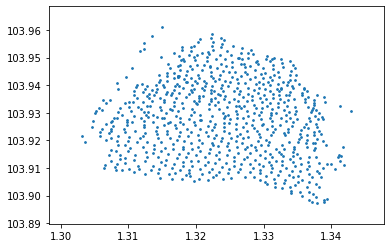

In [144]:
#756 is p_subzone
# %%time
AED_sub.reset

start_time = time.time()

plt.scatter(
   AED_sub['LatAED'], 
   AED_sub['LongAED'],s=3
)

print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
d1 = haverDist(OHCA20a,candidateAED20a)
sub_AED_df = MCLP(100,OHCA20a,candidateAED20a,d1,p_subzone/2)
ALL_AED=ALL_AED.append(sub_AED_df)
# uncomment this when re-run
d1 = haverDist(OHCA20b,candidateAED20b)
OHCA20b.reset_index(drop=True,inplace=True)
candidateAED20b.reset_index(drop=True,inplace=True)
sub_AED_df = MCLP(100,OHCA20b,candidateAED20b,d1,p_subzone/2)
# ALL_AED=ALL_AED.append(sub_AED_df)
# sub_AED_df

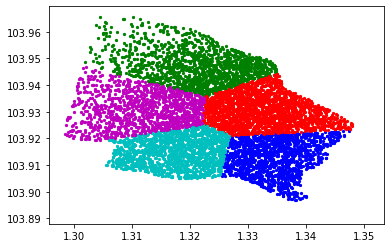

In [125]:
kmeansPlot(OHCA1_clusters,5)

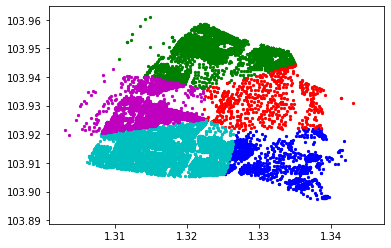

In [127]:
kmeansPlot(candidateAED1_clusters,5)

In [94]:
d1 = haverDist(OHCA20a,candidateAED20a)
sub_AED_df = MCLP(100,OHCA20a,candidateAED20a,d1,p_subzone/2)
ALL_AED=ALL_AED.append(sub_AED_df)
# uncomment this when re-run
d1 = haverDist(OHCA20b,candidateAED20b)
OHCA20b.reset_index(drop=True,inplace=True)
candidateAED20b.reset_index(drop=True,inplace=True)
sub_AED_df = MCLP(100,OHCA20b,candidateAED20b,d1,p_subzone/2)
ALL_AED=ALL_AED.append(sub_AED_df)
sub_AED_df

OHCA Served is =  3340.0


,LatAED,LongAED
2,1.325855,103.910599
4,1.325648,103.910112
21,1.330167,103.904849
27,1.332101,103.904953
31,1.330695,103.905622
...,...,...
16767,1.327854,103.951251
16821,1.328017,103.952696
16847,1.326507,103.953711
16875,1.325381,103.954333


In [ ]:
######################################################################################################
# testing codes for your reference, don't run
######################################################################################################